In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipypb import irange

from DataProcessor import DataProcessor
from seq_mf_ldp import get_scores_generator, fit_restricted
from evaluation import evaluate, evaluation_callback

In [3]:
from seq_mf_ldp import LDP
from yacs.config import CfgNode as CN

# Load and preprocess the data:

In [4]:
data_file_name = "lsapp.csv"

process_data = DataProcessor(
    data_file_name,
    column_names='userid,appid,timestamp',
    session_break_delta='15min',
)

process_data.prepare_data(
    usecols=['userid', 'appid', 'timestamp'],
    test_interval='14d',
    valid_interval='7d',
    min_sess_length=2,
    window="3s",
)

# Define user-contex matrix:
uid2Sui = process_data.get_users_sui(process_data.train, level='userid')

# Gridsearch the model:

In [5]:
# from itertools import product

# rank_range = [32, 128, 256]
# gamma_range = [0.5, 1, 2]
# gain_range = [5e-5, 1e-4]
# niter_range = [1, 10]
# reg_range = [1e-3, 1e-2, 1e-1, 1]
# eta_usage = [True, False]
# c0 = 1
# seed = 13
# show_result = True

# grid = product(rank_range, gamma_range, gain_range, niter_range, reg_range, eta_usage)

# best_params = None
# best_hr = 0.0
# for n_factors, gamma, gain, n_iter, regularization, eta_bool in grid:
#     Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

#     local_factors, global_factors = fit_restricted(
#         Cui,
#         uid2Sui,
#         n_factors,
#         regularization,
#         gain,
#         n_iter=n_iter,
#         seed=seed,
#         evaluation_callback=None,
#         iterator=range,
#         use_eta=eta_bool,
#     )
#     up_generate_scores = get_scores_generator(local_factors, global_factors)
#     metrics_df, user_stats = evaluate(
#         up_generate_scores,
#         process_data.valid_sessions,
#         process_data.seen_interactions,
#     )
#     valid_results = (
#         metrics_df
#         .reset_index()
#         .groupby(["topk"])
#         .mean()[["hr", "mrr", "ndcg"]]
#     )
#     hr = valid_results["hr"][5]

#     if hr > best_hr:
#         best_hr = hr
#         best_params = (n_factors, gamma, gain, n_iter, regularization, eta_bool)
#         if show_result:
#             print(
#                 f"SeqMF:"
#                 + f"\nBest HR@5: {best_hr}; MRR@5: {valid_results['mrr'][5]}"
#                 + f"\nThe best performance parameters:"
#                 + f'\nn_factors={n_factors}, gamma={gamma}, lr={gain}, niter={n_iter}, reg={regularization}, eta={eta_bool}'
#             ) 

In [6]:
best_params = [256, 1, 5e-05, 1, 0.001, True]
c0 = 1
seed = 13
show_result = True

In [7]:
budgets = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
hr_at_5 = []

for budget in budgets:
    system_config = CN()
    system_config.LDP = CN()
    system_config.LDP.PRIVACY_BUDGET = budget
    system_config.LDP.HARMONY = CN()
    system_config.LDP.HARMONY.APPLY = True
    system_config.LDP.HARMONY.k = 1
    system_config.LDP.LAPLACE = CN()
    system_config.LDP.LAPLACE.APPLY = False
    system_config.LDP.SEED = 42
    ldp = LDP(system_config.LDP)

    n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

    Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

    local_factors, global_factors = fit_restricted(
        Cui,
        uid2Sui,
        n_factors,
        regularization,
        gain,
        n_iter=n_iter,
        seed=seed,
        evaluation_callback=None,
        iterator=range,
        use_eta=eta_bool,
        ldp=ldp
    )
    up_generate_scores = get_scores_generator(local_factors, global_factors)

    metrics_df, user_stats = evaluate(
        up_generate_scores,
        process_data.test_sessions,
        process_data.seen_interactions,
    )
    
    new_results = (
        metrics_df
        .reset_index()
        .groupby(["topk"])
        .mean()[["hr", "mrr", "ndcg"]]
    )
    hr_at_5.append(new_results['hr'][5])
    print(budget, new_results['hr'][5])

0.1 0.37976350702916234
0.2 0.381077737818763
0.3 0.39845993209571884
0.5 0.41539884982958586
1 0.46868504625517404
1.5 0.5199146795454371
2 0.5640540374633425
2.5 0.555439249543883
3 0.5920338514430433
3.5 0.5935116593909874
4 0.6140622972452331


In [8]:
budgets = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
hr_at_5_2 = []

for budget in budgets:
    system_config = CN()
    system_config.LDP = CN()
    system_config.LDP.PRIVACY_BUDGET = budget
    system_config.LDP.HARMONY = CN()
    system_config.LDP.HARMONY.APPLY = True
    system_config.LDP.HARMONY.k = 2
    system_config.LDP.LAPLACE = CN()
    system_config.LDP.LAPLACE.APPLY = False
    system_config.LDP.SEED = 42
    ldp = LDP(system_config.LDP)

    n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

    Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

    local_factors, global_factors = fit_restricted(
        Cui,
        uid2Sui,
        n_factors,
        regularization,
        gain,
        n_iter=n_iter,
        seed=seed,
        evaluation_callback=None,
        iterator=range,
        use_eta=eta_bool,
        ldp=ldp
    )
    up_generate_scores = get_scores_generator(local_factors, global_factors)

    metrics_df, user_stats = evaluate(
        up_generate_scores,
        process_data.test_sessions,
        process_data.seen_interactions,
    )
    
    new_results = (
        metrics_df
        .reset_index()
        .groupby(["topk"])
        .mean()[["hr", "mrr", "ndcg"]]
    )
    hr_at_5_2.append(new_results['hr'][5])
    print(budget, new_results['hr'][5])

0.1 0.3984197044901611
0.2 0.39960113960927723
0.3 0.4291775957841711
0.5 0.44271501930729784
1 0.47778306078314153
1.5 0.6137407742378586
2 0.6290021268396098
2.5 0.6676593269295518
3 0.7162398654756462
3.5 0.7280929318937426
4 0.7293348626649298


In [9]:
budgets = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
hr_at_5_5 = []

for budget in budgets:
    system_config = CN()
    system_config.LDP = CN()
    system_config.LDP.PRIVACY_BUDGET = budget
    system_config.LDP.HARMONY = CN()
    system_config.LDP.HARMONY.APPLY = True
    system_config.LDP.HARMONY.k = 5
    system_config.LDP.LAPLACE = CN()
    system_config.LDP.LAPLACE.APPLY = False
    system_config.LDP.SEED = 42
    ldp = LDP(system_config.LDP)

    n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

    Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

    local_factors, global_factors = fit_restricted(
        Cui,
        uid2Sui,
        n_factors,
        regularization,
        gain,
        n_iter=n_iter,
        seed=seed,
        evaluation_callback=None,
        iterator=range,
        use_eta=eta_bool,
        ldp=ldp
    )
    up_generate_scores = get_scores_generator(local_factors, global_factors)

    metrics_df, user_stats = evaluate(
        up_generate_scores,
        process_data.test_sessions,
        process_data.seen_interactions,
    )
    
    new_results = (
        metrics_df
        .reset_index()
        .groupby(["topk"])
        .mean()[["hr", "mrr", "ndcg"]]
    )
    hr_at_5_5.append(new_results['hr'][5])
    print(budget, new_results['hr'][5])

0.1 0.36700038672449387
0.2 0.35601706458460985
0.3 0.37089146586252875
0.5 0.43398654776132667
1 0.6166112455143893
1.5 0.7484428004861075
2 0.7666976464650114
2.5 0.7706124480215306
3 0.7706069150469136
3.5 0.7701033668089823
4 0.7710995119141731


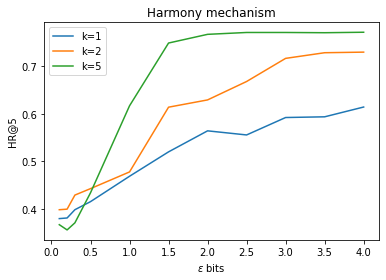

In [16]:
plt.title('Harmony mechanism')
plt.xlabel(r'$\varepsilon$ bits')
plt.ylabel('HR@5')
plt.plot(budgets, hr_at_5, label='k=1')
plt.plot(budgets, hr_at_5_2, label='k=2')
plt.plot(budgets, hr_at_5_5, label='k=5')
plt.legend()
plt.savefig('harmony.pdf', format='pdf', bbox_inches='tight')

In [11]:
budgets = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
hr_at_5_lap = []

for budget in budgets:
    system_config = CN()
    system_config.LDP = CN()
    system_config.LDP.PRIVACY_BUDGET = budget
    system_config.LDP.HARMONY = CN()
    system_config.LDP.HARMONY.APPLY = False
    system_config.LDP.HARMONY.k = 5
    system_config.LDP.LAPLACE = CN()
    system_config.LDP.LAPLACE.APPLY = True
    system_config.LDP.SEED = 42
    ldp = LDP(system_config.LDP)

    n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

    Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

    local_factors, global_factors = fit_restricted(
        Cui,
        uid2Sui,
        n_factors,
        regularization,
        gain,
        n_iter=n_iter,
        seed=seed,
        evaluation_callback=None,
        iterator=range,
        use_eta=eta_bool,
        ldp=ldp
    )
    up_generate_scores = get_scores_generator(local_factors, global_factors)

    metrics_df, user_stats = evaluate(
        up_generate_scores,
        process_data.test_sessions,
        process_data.seen_interactions,
    )
    
    new_results = (
        metrics_df
        .reset_index()
        .groupby(["topk"])
        .mean()[["hr", "mrr", "ndcg"]]
    )
    hr_at_5_lap.append(new_results['hr'][5])
    print(budget, new_results['hr'][5])

0.1 0.35582764303829445
0.2 0.35582764303829445
0.3 0.35582764303829445
0.5 0.35582764303829445
1 0.35582764303829445
1.5 0.35582764303829445
2 0.35582764303829445
2.5 0.3558591927606569
3 0.3558591927606569
3.5 0.3558591927606569
4 0.3559296814824614


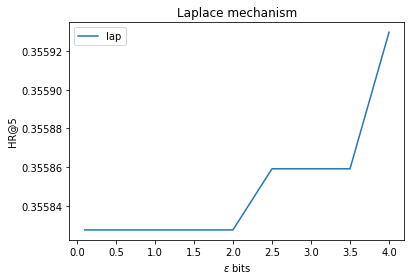

In [13]:
plt.title('Privacy mechanisms')
plt.xlabel(r'$\varepsilon$ bits')
plt.ylabel('HR@5')
plt.plot(budgets, hr_at_5, label='Harmony, k=1')
plt.plot(budgets, hr_at_5_2, label='k=2')
plt.plot(budgets, hr_at_5_5, label='k=5')
plt.plot(budgets, hr_at_5_lap, label='lap')
plt.legend()
plt.savefig('harmony.pdf', format='pdf', bbox_inches='tight')

In [15]:
system_config = CN()
system_config.LDP = CN()
system_config.LDP.PRIVACY_BUDGET = 2
system_config.LDP.HARMONY = CN()
system_config.LDP.HARMONY.APPLY = True
system_config.LDP.HARMONY.k = 5
system_config.LDP.LAPLACE = CN()
system_config.LDP.LAPLACE.APPLY = False
system_config.LDP.SEED = 42
ldp = LDP(system_config.LDP)

n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

local_factors, global_factors = fit_restricted(
    Cui,
    uid2Sui,
    n_factors,
    regularization,
    gain,
    n_iter=n_iter,
    seed=seed,
    evaluation_callback=None,
    iterator=range,
    use_eta=eta_bool,
    ldp=ldp
)
up_generate_scores = get_scores_generator(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

new_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)
new_results

metrics,hr,mrr,ndcg
topk,,,
1,0.246456,0.246456,0.246456
3,0.557077,0.384011,0.428488
5,0.766698,0.430545,0.513621
